## Import libraries

In [552]:
import pandas as pd
import seaborn as sns


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Define functions:

In [983]:
#Function to get metric
def get_metrics_as_dataframe(model_name, metrics_dict):
    model_name = model_name  # Replace with your model's name
    accuracy = metrics_dict['Accuracy']
    precision = metrics_dict['Precision']
    recall = metrics_dict['Recall']
    f1 = metrics_dict['F1 Score']
    
    table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
    })

    return table


## Function to fit loaded model to our dataset
def sentiment_score(review):
    with torch.no_grad():
        tokens = tokenizer.encode(review, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits))+1 # +1 because the model's output is [0,1,2,3,4] and our dataset labels are [1,2,3,4,5]

## Similar function but without +1    
def sentiment_score_2(review):
    with torch.no_grad():
        tokens = tokenizer.encode(review, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits))
    

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_classification(y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

# Example usage:
# y_true = true ratings (ground truth)
# y_pred = predicted ratings (output of your sentiment analysis model)
# results = evaluate_classification(y_true, y_pred)
# print(results)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example usage:
class_names_1 = ['1', '2', '3', '4', '5']
class_names_2 = ['0', '1', '2']
class_names_3 = ['0', '1']


def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Calculate the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Calculate row-wise sums (total predictions for each class)
    row_sums = confusion.sum(axis=1)

    # Create a larger heatmap using Seaborn
    plt.figure(figsize=(10, 8))

    # Create the heatmap
    heatmap = sns.heatmap(confusion / row_sums[:, np.newaxis], annot=True, fmt=".1%", cmap='Blues', cbar=False)

    # Customize the plot
    plt.xlabel('Predicted', fontsize=14)  # You can adjust font size
    plt.ylabel('True', fontsize=14)       # You can adjust font size

    # Add class names as tick labels for both axes, centered between the boxes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks + 0.5, class_names, rotation=0)  # Adjusted to center labels
    plt.yticks(tick_marks + 0.5, class_names, rotation=0)   # Adjusted to center labels

    plt.title('Confusion Matrix (in Percentage)', fontsize=16)  # You can adjust font size

    # Show the plot
    plt.show()




## Load dataset

In [553]:
df = pd.read_csv('womens_clothing_ecommerce_reviews.csv')

In [554]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Data preprocessing

In [555]:
sentiment = df[['Rating', 'Review Text', 'Class Name']]
sentiment.head()

,Rating,Review Text,Class Name
0,4,If this product was in petite i would get the...,Blouses
1,5,Love this dress! it's sooo pretty. i happene...,Dresses
2,3,I had such high hopes for this dress and reall...,Dresses
3,5,I love love love this jumpsuit. it's fun fl...,Pants
4,5,This shirt is very flattering to all due to th...,Blouses


In [556]:
df_transformed = sentiment.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})

In [557]:
df_transformed.head()

,star_rating,review_body,product_category
0,4,If this product was in petite i would get the...,Blouses
1,5,Love this dress! it's sooo pretty. i happene...,Dresses
2,3,I had such high hopes for this dress and reall...,Dresses
3,5,I love love love this jumpsuit. it's fun fl...,Pants
4,5,This shirt is very flattering to all due to th...,Blouses


In [558]:
df_transformed.shape

(23486, 3)

In [559]:
#check forNaN values
df_transformed.isna().sum()

star_rating           0
review_body         845
product_category     14
dtype: int64

<Axes: >

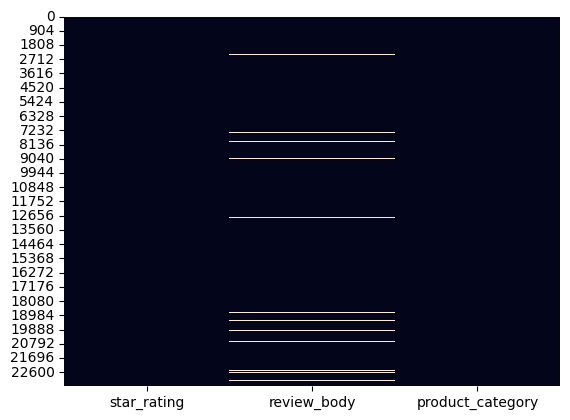

In [560]:
sns.heatmap(df_transformed.isna(), cbar=False)

In [561]:
#remove NaN
df_transformed.dropna(inplace=True)

In [562]:
df_transformed.shape

(22628, 3)

In [563]:
df_transformed.duplicated().sum()

6

In [564]:
# Assuming df_transformed is your DataFrame
df_transformed.drop_duplicates(inplace=True)

# Now, if you check the number of duplicated rows, it should be 0
print(df_transformed.duplicated().sum())


0


In [565]:
df_transformed.head()

,star_rating,review_body,product_category
0,4,If this product was in petite i would get the...,Blouses
1,5,Love this dress! it's sooo pretty. i happene...,Dresses
2,3,I had such high hopes for this dress and reall...,Dresses
3,5,I love love love this jumpsuit. it's fun fl...,Pants
4,5,This shirt is very flattering to all due to th...,Blouses


In [566]:
df_transformed.reset_index(drop=True, inplace=True )
df_transformed

,star_rating,review_body,product_category
0,4,If this product was in petite i would get the...,Blouses
1,5,Love this dress! it's sooo pretty. i happene...,Dresses
2,3,I had such high hopes for this dress and reall...,Dresses
3,5,I love love love this jumpsuit. it's fun fl...,Pants
4,5,This shirt is very flattering to all due to th...,Blouses
...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses
22618,3,It reminds me of maternity clothes. soft stre...,Knits
22619,3,This fit well but the top was very see throug...,Dresses
22620,3,I bought this dress for a wedding i have this ...,Dresses


In [567]:
# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['star_rating', 'review_body', 'product_category']]

df_transformed.shape

(22620, 3)

## EDA (Exploratory Data Analysis)

In [635]:
count_sentiment = df_transformed.groupby('star_rating')['review_body'].count()
count_sentiment

star_rating
1      821
2     1548
3     2823
4     4906
5    12522
Name: review_body, dtype: int64

### Find out how many reviews per sentiment

<Axes: xlabel='star_rating'>

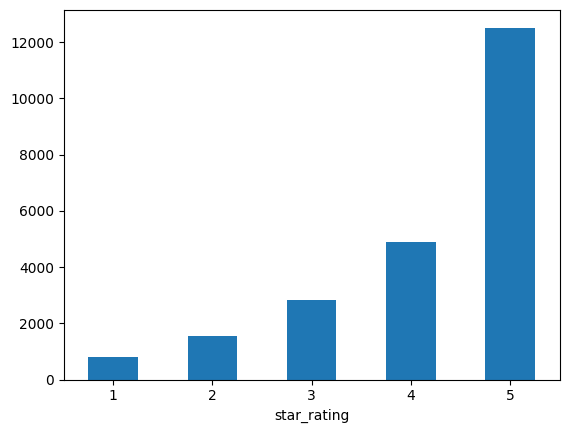

In [636]:
count_sentiment.plot(kind='bar', x='star_rating', y='count_sentiment', rot=0)

### Find out number of reviews per category

In [641]:
count_sentiment_per_category = df_transformed.groupby('product_category')['star_rating'].count()
count_sentiment_per_category.sort_values(ascending=False)

product_category
Dresses       6144
Knits         4625
Blouses       2983
Sweaters      1380
Pants         1350
Jeans         1103
Fine gauge    1059
Skirts         903
Jackets        683
Lounge         668
Swim           330
Outerwear      319
Shorts         304
Sleep          214
Legwear        158
Intimates      147
Layering       132
Trend          118
Name: star_rating, dtype: int64

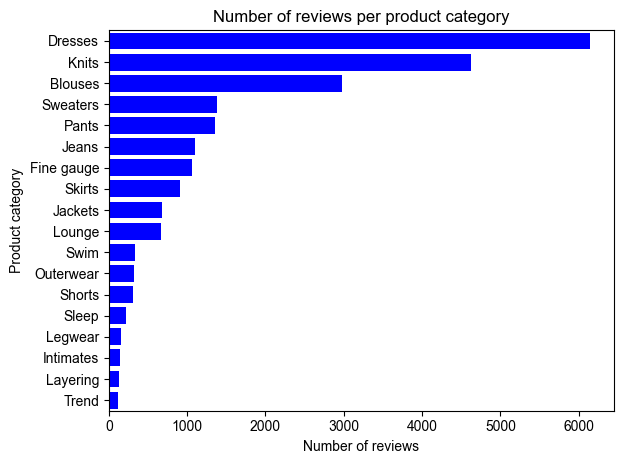

In [642]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by product category and count the number of reviews in each category
count_sentiment_per_category = count_sentiment_per_category.sort_values(ascending=False)

# Create a barplot using seaborn
barplot = sns.barplot(
    data=count_sentiment_per_category.reset_index(),  # Reset the index to have 'product_category' as a column
    y='product_category',
    x='star_rating',
    color="b",
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize': (15.0, 10.0)})

# Set title and labels
plt.title("Number of reviews per product category")
plt.xlabel("Number of reviews")
plt.ylabel("Product category")

# Save the plot as an image
plt.tight_layout()
plt.savefig('num_reviews_per_category.png', dpi=300)

# Show the barplot
plt.show()


### Plot distribution of reviews per sentiment per category

In [659]:
# Group the data by 'product_category' and 'star_rating', then count the reviews
grouped = df_transformed.groupby(['product_category', 'star_rating']).size().reset_index(name='count_reviews')

# Sort the DataFrame as requested
result = grouped.sort_values(by=['product_category', 'star_rating'], ascending=[True, False])
print(result)


   product_category  star_rating  count_reviews
4           Blouses            5           1611
3           Blouses            4            645
2           Blouses            3            384
1           Blouses            2            228
0           Blouses            1            115
..              ...          ...            ...
89            Trend            5             52
88            Trend            4             26
87            Trend            3             19
86            Trend            2             11
85            Trend            1             10

[90 rows x 3 columns]


In [663]:
count_reviews = pd.DataFrame(result)
count_reviews.reset_index(drop=True, inplace=True)
count_reviews

,product_category,star_rating,count_reviews
0,Blouses,5,1611
1,Blouses,4,645
2,Blouses,3,384
3,Blouses,2,228
4,Blouses,1,115
...,...,...,...
85,Trend,5,52
86,Trend,4,26
87,Trend,3,19
88,Trend,2,11


In [665]:
# Create grouped dataframes by category and by sentiment
grouped_category = count_reviews.groupby('product_category')
grouped_star = count_reviews.groupby('star_rating')

# Create sum of sentiments per star sentiment
df_sum = count_reviews.groupby(['star_rating']).sum()

# Calculate total number of sentiments
total = df_sum['count_reviews'].sum()
print('Total number of reviews: {}'.format(total))

Total number of reviews: 22620


In [669]:
distribution = {}
count_reviews_per_rating = []
i=0

for category, ratings in grouped_category:
    count_reviews_per_rating = []
    for star in ratings['star_rating']:
        count_reviews_per_rating.append(ratings.at[i, 'count_reviews'])
        i=i+1;
    distribution[category] = count_reviews_per_rating

distribution

{'Blouses': [1611, 645, 384, 228, 115],
 'Dresses': [3267, 1367, 830, 458, 222],
 'Fine gauge': [608, 229, 118, 74, 30],
 'Intimates': [91, 26, 16, 8, 6],
 'Jackets': [436, 114, 61, 38, 34],
 'Jeans': [693, 215, 110, 55, 30],
 'Knits': [2448, 1074, 605, 324, 174],
 'Layering': [78, 35, 9, 7, 3],
 'Legwear': [97, 29, 16, 6, 10],
 'Lounge': [393, 151, 78, 24, 22],
 'Outerwear': [173, 81, 29, 22, 14],
 'Pants': [792, 282, 154, 81, 41],
 'Shorts': [175, 65, 39, 16, 9],
 'Skirts': [515, 199, 104, 51, 34],
 'Sleep': [134, 41, 16, 14, 9],
 'Sweaters': [776, 260, 193, 103, 48],
 'Swim': [183, 67, 42, 28, 10],
 'Trend': [52, 26, 19, 11, 10]}

In [670]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(
    lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis=1
)
df_distribution_pct.columns=['5', '4', '3','2', '1']
df_distribution_pct

,5,4,3,2,1
Blouses,54.006034,21.622528,12.872947,7.643312,3.855179
Dresses,53.173828,22.249349,13.509115,7.454427,3.613281
Fine gauge,57.412653,21.624174,11.142587,6.987724,2.832861
Intimates,61.904762,17.687075,10.884354,5.442177,4.081633
Jackets,63.836018,16.691069,8.931186,5.563690,4.978038
Jeans,62.828649,19.492294,9.972801,4.986401,2.719855
Knits,52.929730,23.221622,13.081081,7.005405,3.762162
Layering,59.090909,26.515152,6.818182,5.303030,2.272727
Legwear,61.392405,18.354430,10.126582,3.797468,6.329114
Lounge,58.832335,22.604790,11.676647,3.592814,3.293413


<Figure size 1000x500 with 0 Axes>

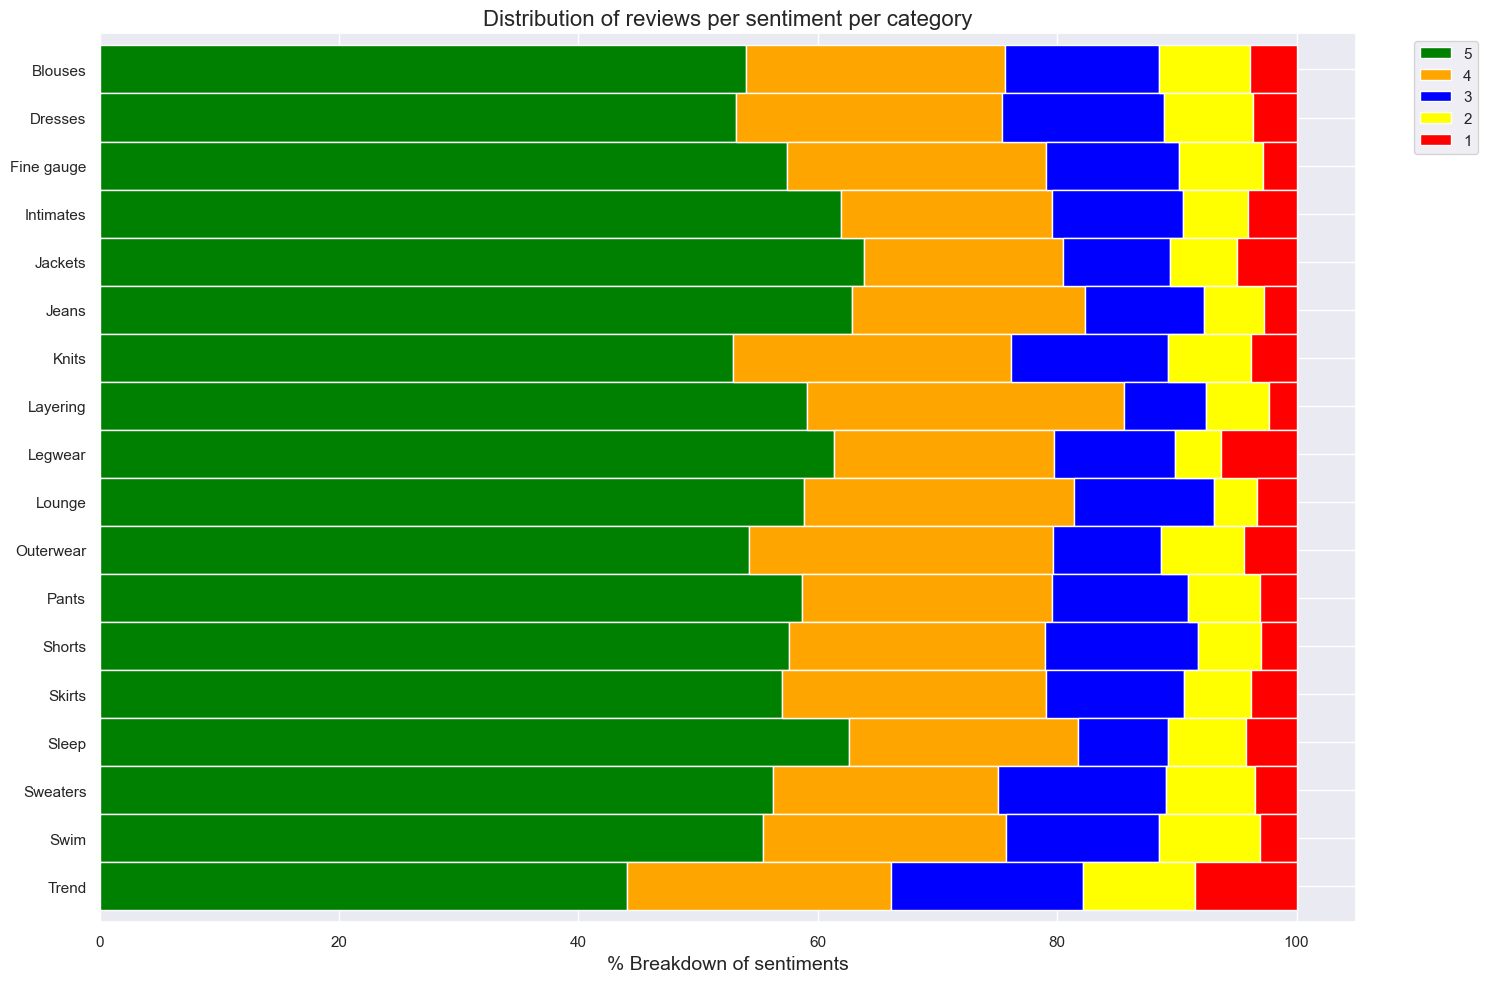

In [798]:
categories = df_distribution_pct.index

# Plot bars
plt.figure(figsize=(10,5))

df_distribution_pct.plot(kind="barh", 
                         stacked=True, 
                         edgecolor='white',
                         width=1.0,
                         color=['green', 
                                'orange', 
                                'blue',
                                'yellow',
                                'red'])

plt.title("Distribution of reviews per sentiment per category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['5', 
                   '4', 
                   '3',
                   '2',
                   '1'])

plt.xlabel("% Breakdown of sentiments", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Plot a sentiment word cloud

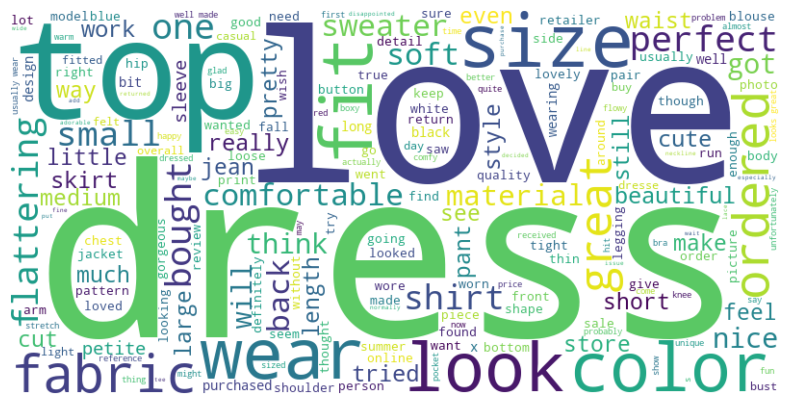

In [571]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract the text data from the "review_body" column in your DataFrame
text_data = " ".join(df_transformed['review_body'])

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Plot distribution of words per review (This information is used for fine-tuning a bert model later on)

In [799]:
df_transformed

,star_rating,review_body,product_category
0,4,If this product was in petite i would get the...,Blouses
1,5,Love this dress! it's sooo pretty. i happene...,Dresses
2,3,I had such high hopes for this dress and reall...,Dresses
3,5,I love love love this jumpsuit. it's fun fl...,Pants
4,5,This shirt is very flattering to all due to th...,Blouses
...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses
22618,3,It reminds me of maternity clothes. soft stre...,Knits
22619,3,This fit well but the top was very see throug...,Dresses
22620,3,I bought this dress for a wedding i have this ...,Dresses


In [800]:
#count the amount of words in each review
df_transformed['count'] = df_transformed['review_body'].apply(lambda x: len(x.split()))
df_transformed

,star_rating,review_body,product_category,count
0,4,If this product was in petite i would get the...,Blouses,60
1,5,Love this dress! it's sooo pretty. i happene...,Dresses,62
2,3,I had such high hopes for this dress and reall...,Dresses,98
3,5,I love love love this jumpsuit. it's fun fl...,Pants,22
4,5,This shirt is very flattering to all due to th...,Blouses,36
...,...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses,28
22618,3,It reminds me of maternity clothes. soft stre...,Knits,38
22619,3,This fit well but the top was very see throug...,Dresses,42
22620,3,I bought this dress for a wedding i have this ...,Dresses,86


In [801]:
#Find out the max words across all reviews
df_transformed['count'].max()

115

<Figure size 800x800 with 0 Axes>

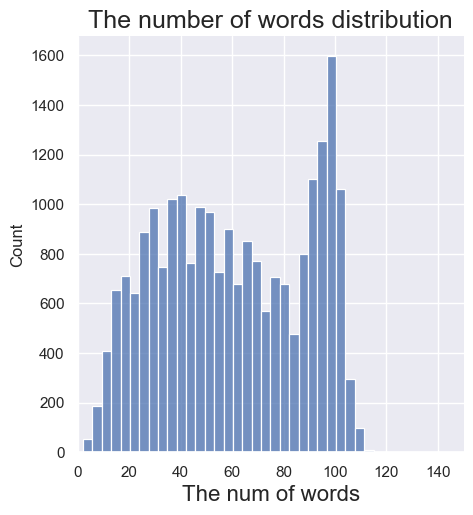

In [802]:
#Plot distribution of words
import seaborn as sns
plt.figure(figsize=(8,8))
sns.displot(df_transformed['count'])
plt.xlim(0,150)
plt.xlabel('The num of words', fontsize=16)
plt.title('The number of words distribution', fontsize=18)
plt.show()

# Perform inference on dataset to predict sentiment using pre-trained models from huggingface

## First model to try out: BERT model pre-trained to produce 5 classes which is suitable for our dataset which has 5 ratings (1,2,3,4,5)

#### Import model from huggingface (nlptown/bert-base-multilingual-uncased-sentiment)

In [807]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np


model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # Replace with a valid model name from Hugging Face's model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)






## Test out model on single data (encode and fit model)

#### Encode and calculate sentiment 


In [573]:
tokens = tokenizer.encode('I love this, absolutely the best!', return_tensors='pt')
result = model(tokens)
result 

SequenceClassifierOutput(loss=None, logits=tensor([[-2.4798, -2.7428, -1.5865,  1.0678,  4.7910]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [574]:
#argmax get highest value
#logits=tensor([[-2.4798, -2.7428, -1.5865,  1.0678,  4.7910]]
int(torch.argmax(result.logits))+1

5

### Prepare data for inference on whole dataset

In [803]:
df_transformed

,star_rating,review_body,product_category,count
0,4,If this product was in petite i would get the...,Blouses,60
1,5,Love this dress! it's sooo pretty. i happene...,Dresses,62
2,3,I had such high hopes for this dress and reall...,Dresses,98
3,5,I love love love this jumpsuit. it's fun fl...,Pants,22
4,5,This shirt is very flattering to all due to th...,Blouses,36
...,...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses,28
22618,3,It reminds me of maternity clothes. soft stre...,Knits,38
22619,3,This fit well but the top was very see throug...,Dresses,42
22620,3,I bought this dress for a wedding i have this ...,Dresses,86


In [804]:
review = df_transformed['review_body']
review

0        If this product was in petite  i would get the...
1        Love this dress!  it's sooo pretty.  i happene...
2        I had such high hopes for this dress and reall...
3        I love  love  love this jumpsuit. it's fun  fl...
4        This shirt is very flattering to all due to th...
                               ...                        
22617    I was very happy to snag this dress at such a ...
22618    It reminds me of maternity clothes. soft  stre...
22619    This fit well  but the top was very see throug...
22620    I bought this dress for a wedding i have this ...
22621    This dress in a lovely platinum is feminine an...
Name: review_body, Length: 22620, dtype: object

In [805]:
#convert into dataframe

text = pd.DataFrame(np.array(review), columns=['reviews'])
text

,reviews
0,If this product was in petite i would get the...
1,Love this dress! it's sooo pretty. i happene...
2,I had such high hopes for this dress and reall...
3,I love love love this jumpsuit. it's fun fl...
4,This shirt is very flattering to all due to th...
...,...
22615,I was very happy to snag this dress at such a ...
22616,It reminds me of maternity clothes. soft stre...
22617,This fit well but the top was very see throug...
22618,I bought this dress for a wedding i have this ...


In [806]:
text['reviews'].iloc[0]

"If this product was in petite  i would get the petite. the regular is a little long on me but a tailor can do a simple fix on that.     fits nicely! i'm 5'4  130lb and pregnant so i bough t medium to grow into.     the tie can be front or back so provides for some nice flexibility on form fitting."

### Inference 

In [582]:
# Assuming 'text' is a DataFrame with a 'reviews' column
#text['sentiment'] = text['reviews'].apply(lambda x: sentiment_score(x))
    

In [583]:
#Save prediction as csv
#text.to_csv('five_class_prediction.csv')

In [945]:
#Read in prediction
five_class = pd.read_csv('./predicted/five_class.csv')
five_class.drop(columns='Unnamed: 0')

,reviews,sentiment
0,If this product was in petite i would get the...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,I love love love this jumpsuit. it's fun fl...,5
4,This shirt is very flattering to all due to th...,5
...,...,...
22615,I was very happy to snag this dress at such a ...,5
22616,It reminds me of maternity clothes. soft stre...,3
22617,This fit well but the top was very see throug...,3
22618,I bought this dress for a wedding i have this ...,3


In [946]:
df_transformed

,star_rating,review_body,product_category,count
0,4,If this product was in petite i would get the...,Blouses,60
1,5,Love this dress! it's sooo pretty. i happene...,Dresses,62
2,3,I had such high hopes for this dress and reall...,Dresses,98
3,5,I love love love this jumpsuit. it's fun fl...,Pants,22
4,5,This shirt is very flattering to all due to th...,Blouses,36
...,...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses,28
22618,3,It reminds me of maternity clothes. soft stre...,Knits,38
22619,3,This fit well but the top was very see throug...,Dresses,42
22620,3,I bought this dress for a wedding i have this ...,Dresses,86


In [947]:
#Get ground_truth label
ground_truth = df_transformed['star_rating']
ground_truth

0        4
1        5
2        3
3        5
4        5
        ..
22617    5
22618    3
22619    3
22620    3
22621    5
Name: star_rating, Length: 22620, dtype: int64

In [948]:
predicted = five_class['sentiment']
predicted

0        4
1        5
2        3
3        5
4        5
        ..
22615    5
22616    3
22617    3
22618    3
22619    5
Name: sentiment, Length: 22620, dtype: int64

## Evaluation

In [815]:
five_class_metrics = evaluate_classification(ground_truth, predicted)

In [820]:
five_class_table = get_metrics_as_dataframe("BERT base (5 classes)", five_class_metrics)
five_class_table

,Model,Accuracy,Precision,Recall,F1 Score
0,BERT base (5 classes),0.566092,0.653298,0.566092,0.592059


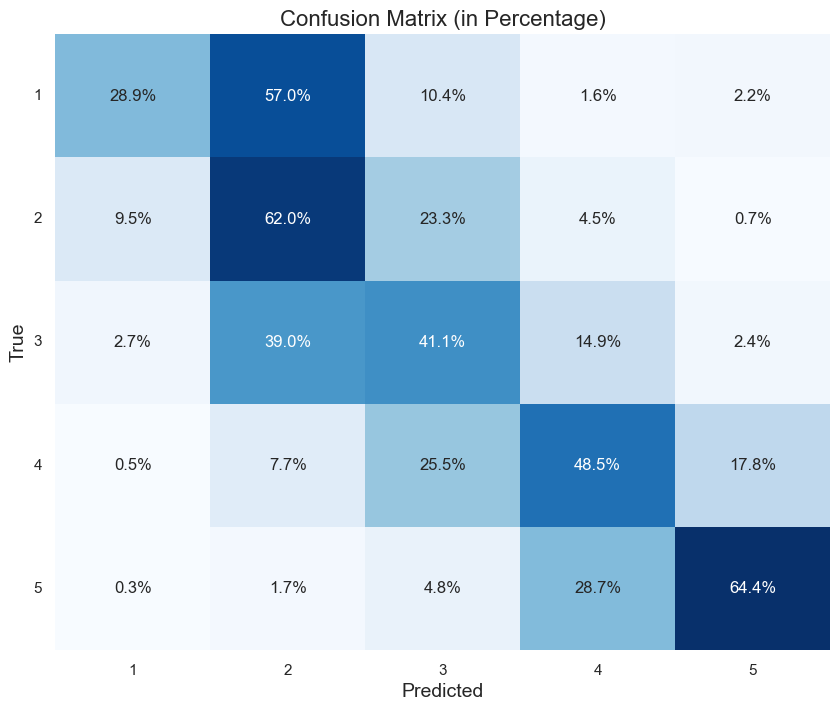

In [984]:
#Plot confusion matrix
plot_confusion_matrix(ground_truth, predicted, class_names_1)

## Second model to try out: BERT model pre-trained to produce 3 classes (Negative, Neutral and Positive)

In [821]:
##Load model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # Replace with a valid model name from Hugging Face's model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [822]:
three_class = df_transformed.copy()
three_class


,star_rating,review_body,product_category,count
0,4,If this product was in petite i would get the...,Blouses,60
1,5,Love this dress! it's sooo pretty. i happene...,Dresses,62
2,3,I had such high hopes for this dress and reall...,Dresses,98
3,5,I love love love this jumpsuit. it's fun fl...,Pants,22
4,5,This shirt is very flattering to all due to th...,Blouses,36
...,...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses,28
22618,3,It reminds me of maternity clothes. soft stre...,Knits,38
22619,3,This fit well but the top was very see throug...,Dresses,42
22620,3,I bought this dress for a wedding i have this ...,Dresses,86


### Convert original 5 star rating into 3 classes (0,1,2) [0:negative, 1:neutral, 2:positive]

In [823]:
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return 0 
    if star_rating == 3:      # neutral
        return 1
    if star_rating in {4, 5}: # positive
        return 2

# transform star_rating into the sentiment
three_class['sentiment'] = three_class['star_rating'].apply(lambda star_rating: to_sentiment(star_rating=star_rating))

# drop the star rating column
three_class.drop(columns=['star_rating'],
                    inplace=True)

three_class

,review_body,product_category,count,sentiment
0,If this product was in petite i would get the...,Blouses,60,2
1,Love this dress! it's sooo pretty. i happene...,Dresses,62,2
2,I had such high hopes for this dress and reall...,Dresses,98,1
3,I love love love this jumpsuit. it's fun fl...,Pants,22,2
4,This shirt is very flattering to all due to th...,Blouses,36,2
...,...,...,...,...
22617,I was very happy to snag this dress at such a ...,Dresses,28,2
22618,It reminds me of maternity clothes. soft stre...,Knits,38,1
22619,This fit well but the top was very see throug...,Dresses,42,1
22620,I bought this dress for a wedding i have this ...,Dresses,86,1


## Save a copy of three_class into a csv (will be used for google colab's fine-tuning)

In [825]:
three_class.to_csv('cleaned.csv')

In [827]:
three_class['review_body'][1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store  and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [829]:
#Test on single data
sentiment_score_2(three_class['review_body'][1])

    

2

### Prepare input data for inference

In [832]:
three_class_input = three_class['review_body']
three_class_input = pd.DataFrame(three_class['review_body'])
three_class_input

,review_body
0,If this product was in petite i would get the...
1,Love this dress! it's sooo pretty. i happene...
2,I had such high hopes for this dress and reall...
3,I love love love this jumpsuit. it's fun fl...
4,This shirt is very flattering to all due to th...
...,...
22617,I was very happy to snag this dress at such a ...
22618,It reminds me of maternity clothes. soft stre...
22619,This fit well but the top was very see throug...
22620,I bought this dress for a wedding i have this ...


## Perform inference

In [614]:
#three_class_input['predicted_sentiment'] = three_class_input['review_body'].apply(lambda x: sentiment_score_2(x))

In [621]:
#Save predicted table as csv
#three_class_input.to_csv('three_class_pred.csv')

In [986]:
#Read predicted csv
three_class_pred = pd.read_csv('./predicted/three_class_pred.csv')

In [987]:
ypred = three_class_pred['predicted_sentiment']
ypred

0        2
1        2
2        2
3        2
4        2
        ..
22615    2
22616    2
22617    0
22618    0
22619    2
Name: predicted_sentiment, Length: 22620, dtype: int64

In [988]:
original = three_class['sentiment']
original

0        2
1        2
2        1
3        2
4        2
        ..
22617    2
22618    1
22619    1
22620    1
22621    2
Name: sentiment, Length: 22620, dtype: int64

## Evaluate model

In [989]:
three_class_metrics = evaluate_classification(original, ypred)

In [990]:
three_class_table = get_metrics_as_dataframe("Three_class_table", three_class_metrics)
three_class_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Three_class_table,0.793413,0.771015,0.793413,0.776169


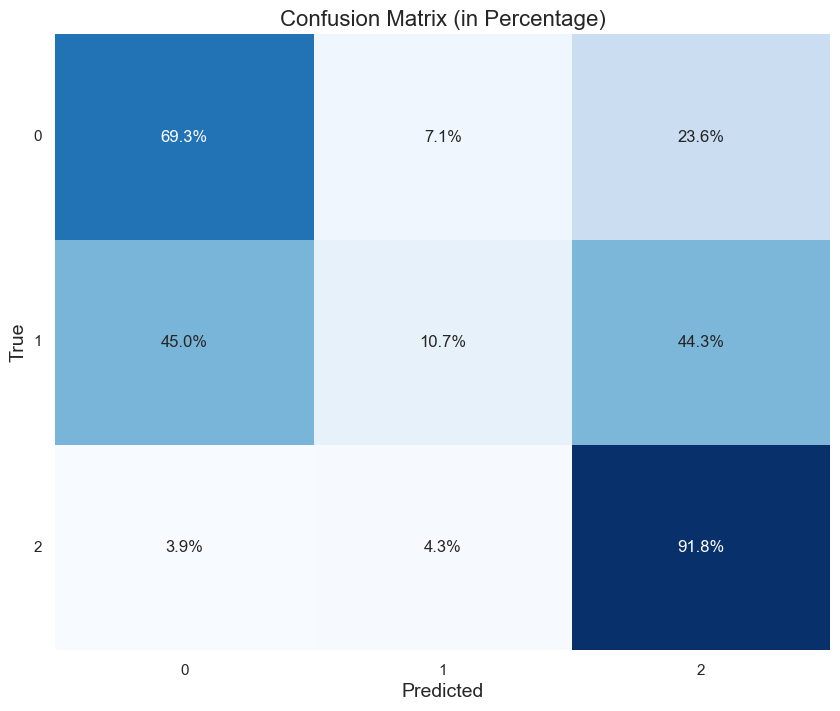

In [985]:
## Plot confusion matrix
plot_confusion_matrix(original,ypred,class_names_2)

## Third model using Binary classification (positive, negative)

### Load model

In [842]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

##Load model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # Replace with a valid model name from Hugging Face's model hub
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

In [843]:
df_transformed

,star_rating,review_body,product_category,count
0,4,If this product was in petite i would get the...,Blouses,60
1,5,Love this dress! it's sooo pretty. i happene...,Dresses,62
2,3,I had such high hopes for this dress and reall...,Dresses,98
3,5,I love love love this jumpsuit. it's fun fl...,Pants,22
4,5,This shirt is very flattering to all due to th...,Blouses,36
...,...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses,28
22618,3,It reminds me of maternity clothes. soft stre...,Knits,38
22619,3,This fit well but the top was very see throug...,Dresses,42
22620,3,I bought this dress for a wedding i have this ...,Dresses,86


In [844]:
binary_class = df_transformed.copy()
binary_class

,star_rating,review_body,product_category,count
0,4,If this product was in petite i would get the...,Blouses,60
1,5,Love this dress! it's sooo pretty. i happene...,Dresses,62
2,3,I had such high hopes for this dress and reall...,Dresses,98
3,5,I love love love this jumpsuit. it's fun fl...,Pants,22
4,5,This shirt is very flattering to all due to th...,Blouses,36
...,...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses,28
22618,3,It reminds me of maternity clothes. soft stre...,Knits,38
22619,3,This fit well but the top was very see throug...,Dresses,42
22620,3,I bought this dress for a wedding i have this ...,Dresses,86


### Convert star rating into binary labels

In [845]:
def to_binary_sentiment(star_rating):
    if star_rating in {1, 2, 3}: # Negative
        return 0 
    if star_rating in {4, 5}:      # Positive
        return 1

# Transform star_rating into the sentiment
binary_class['sentiment'] = binary_class['star_rating'].apply(lambda star_rating: to_binary_sentiment(star_rating=star_rating))

# Drop the star rating column
binary_class.drop(columns=['star_rating'], inplace=True)

binary_class


,review_body,product_category,count,sentiment
0,If this product was in petite i would get the...,Blouses,60,1
1,Love this dress! it's sooo pretty. i happene...,Dresses,62,1
2,I had such high hopes for this dress and reall...,Dresses,98,0
3,I love love love this jumpsuit. it's fun fl...,Pants,22,1
4,This shirt is very flattering to all due to th...,Blouses,36,1
...,...,...,...,...
22617,I was very happy to snag this dress at such a ...,Dresses,28,1
22618,It reminds me of maternity clothes. soft stre...,Knits,38,0
22619,This fit well but the top was very see throug...,Dresses,42,0
22620,I bought this dress for a wedding i have this ...,Dresses,86,0


In [846]:
#Test out on single data
sentiment_score_2(binary_class['review_body'][0])

1

## Inference

In [701]:
#binary_class['predicted_sentiment'] = binary_class['review_body'].apply(lambda x: sentiment_score_3(x))


In [710]:
#save predicton as csv
#binary_class.to_csv('binary_pred.csv')

In [991]:
#Read in prediction
binary_pred = pd.read_csv('./predicted/binary_pred.csv')
binary_pred

,Unnamed: 0,review_body,product_category,sentiment,predicted_sentiment
0,0,If this product was in petite i would get the...,Blouses,1,1
1,1,Love this dress! it's sooo pretty. i happene...,Dresses,1,1
2,2,I had such high hopes for this dress and reall...,Dresses,0,1
3,3,I love love love this jumpsuit. it's fun fl...,Pants,1,1
4,4,This shirt is very flattering to all due to th...,Blouses,1,1
...,...,...,...,...,...
22615,22617,I was very happy to snag this dress at such a ...,Dresses,1,1
22616,22618,It reminds me of maternity clothes. soft stre...,Knits,0,1
22617,22619,This fit well but the top was very see throug...,Dresses,0,1
22618,22620,I bought this dress for a wedding i have this ...,Dresses,0,0


In [992]:
original = binary_pred['sentiment']
ypred = binary_pred['predicted_sentiment']

In [993]:
binary_metrics = evaluate_classification(original, ypred)
binary_metrics

{'Accuracy': 0.8372236958443855,
 'Precision': 0.8496382951756084,
 'Recall': 0.8372236958443855,
 'F1 Score': 0.8417815862826272,
 'Confusion Matrix': array([[ 3828,  1364],
        [ 2318, 15110]], dtype=int64)}

In [994]:
binary_table = get_metrics_as_dataframe("binary classification", binary_metrics)
binary_table

,Model,Accuracy,Precision,Recall,F1 Score
0,binary classification,0.837224,0.849638,0.837224,0.841782


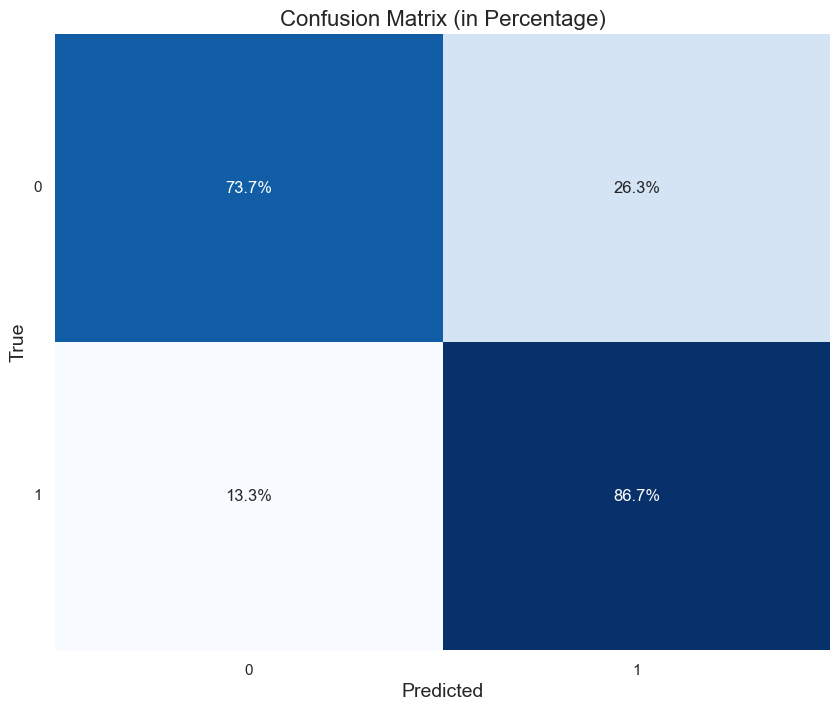

In [995]:
## Plot confusion matrix
plot_confusion_matrix(original, ypred, class_names_3)

In [708]:
df_transformed

,star_rating,review_body,product_category
0,4,If this product was in petite i would get the...,Blouses
1,5,Love this dress! it's sooo pretty. i happene...,Dresses
2,3,I had such high hopes for this dress and reall...,Dresses
3,5,I love love love this jumpsuit. it's fun fl...,Pants
4,5,This shirt is very flattering to all due to th...,Blouses
...,...,...,...
22617,5,I was very happy to snag this dress at such a ...,Dresses
22618,3,It reminds me of maternity clothes. soft stre...,Knits
22619,3,This fit well but the top was very see throug...,Dresses
22620,3,I bought this dress for a wedding i have this ...,Dresses


## Fine-tuned distilbert-base-uncased model for 3 classes sentiment analysis (positive, neutral and negative) 


In [998]:
##Load model after model is uploaded to huggingface hub
model_name = "ongaunjie/distilbert-cloths-sentiment"  # Replace with a valid model name from Hugging Face's model hub
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

In [867]:
fine_tuned = three_class.copy()
fine_tuned

,review_body,product_category,count,sentiment
0,If this product was in petite i would get the...,Blouses,60,2
1,Love this dress! it's sooo pretty. i happene...,Dresses,62,2
2,I had such high hopes for this dress and reall...,Dresses,98,1
3,I love love love this jumpsuit. it's fun fl...,Pants,22,2
4,This shirt is very flattering to all due to th...,Blouses,36,2
...,...,...,...,...
22617,I was very happy to snag this dress at such a ...,Dresses,28,2
22618,It reminds me of maternity clothes. soft stre...,Knits,38,1
22619,This fit well but the top was very see throug...,Dresses,42,1
22620,I bought this dress for a wedding i have this ...,Dresses,86,1


In [868]:
tuned = fine_tuned['review_body']
tuned

0        If this product was in petite  i would get the...
1        Love this dress!  it's sooo pretty.  i happene...
2        I had such high hopes for this dress and reall...
3        I love  love  love this jumpsuit. it's fun  fl...
4        This shirt is very flattering to all due to th...
                               ...                        
22617    I was very happy to snag this dress at such a ...
22618    It reminds me of maternity clothes. soft  stre...
22619    This fit well  but the top was very see throug...
22620    I bought this dress for a wedding i have this ...
22621    This dress in a lovely platinum is feminine an...
Name: review_body, Length: 22620, dtype: object

In [862]:
tuned_df = pd.DataFrame(tuned)
tuned_df

,review_body
0,If this product was in petite i would get the...
1,Love this dress! it's sooo pretty. i happene...
2,I had such high hopes for this dress and reall...
3,I love love love this jumpsuit. it's fun fl...
4,This shirt is very flattering to all due to th...
...,...
22617,I was very happy to snag this dress at such a ...
22618,It reminds me of maternity clothes. soft stre...
22619,This fit well but the top was very see throug...
22620,I bought this dress for a wedding i have this ...


In [869]:
tuned_df['review_body'][1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store  and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [870]:
#test model on single data
sentiment_score_2(tuned_df['review_body'][1])

2

## Inference 

In [872]:
#inference on full dataset
#tuned_df['predicted_sentiment'] = tuned_df['review_body'].apply(lambda x: sentiment_score_2(x))

In [873]:
## Save prediction
tuned_df.to_csv('tuned_full_data_pred.csv')

In [874]:
## Load prediction csv
tuned_full_pred = pd.read_csv('tuned_full_data_pred.csv')

In [877]:
tuned_full_pred.drop('Unnamed: 0', axis=1, inplace=True)
tuned_full_pred

,review_body,predicted_sentiment
0,If this product was in petite i would get the...,2
1,Love this dress! it's sooo pretty. i happene...,2
2,I had such high hopes for this dress and reall...,1
3,I love love love this jumpsuit. it's fun fl...,2
4,This shirt is very flattering to all due to th...,2
...,...,...
22615,I was very happy to snag this dress at such a ...,2
22616,It reminds me of maternity clothes. soft stre...,1
22617,This fit well but the top was very see throug...,1
22618,I bought this dress for a wedding i have this ...,1


## Expected high since this dataset was used to fine-tune the distilbert model

In [911]:
original = fine_tuned['sentiment']
ypred = tuned_full_pred['predicted_sentiment']
tuned_full_data = evaluate_classification(original,ypred)
tuned_full_data

{'Accuracy': 0.9702033598585322,
 'Precision': 0.970677230610605,
 'Recall': 0.9702033598585322,
 'F1 Score': 0.9703566470175023,
 'Confusion Matrix': array([[ 2154,   169,    46],
        [  113,  2585,   125],
        [   24,   197, 17207]], dtype=int64)}

In [913]:
tuned_full_table = get_metrics_as_dataframe("tuned_full_table", tuned_full_data)
tuned_full_table

,Model,Accuracy,Precision,Recall,F1 Score
0,tuned_full_table,0.970203,0.970677,0.970203,0.970357


## Evaluate metrics on test_dataset that has not been seen (train_test_split from google colab)

In [999]:
test_data = pd.read_csv('./test data and label/test_dataset.csv')
test_data.drop('Unnamed: 0', axis=1, inplace=True)
test_data.rename(columns={'0': 'reviews'}, inplace=True)
test_data


,reviews
0,Fit is perfect! very flattering. they are very...
1,Gorgeous skirt. runs a bit big. well made. pe...
2,I bought this dress in the red option. was a l...
3,I purchased this sweater in my usual xs but f...
4,I like this layer for fall for many reasons. f...
...,...
2031,I bought this jacket in white specifically for...
2032,Every spring/summer i look forward to t.la's t...
2033,Bought these online - sale and am really happ...
2034,This top is soo pretty with a cool edge. it l...


In [1000]:
#Inference on testdata
#test_data['predicted_sentiment'] = test_data['reviews'].apply(lambda x: sentiment_score_2(x))

In [ ]:
#save prediction as csv
#test_data.to_csv('./predicted/tuned_test_pred.csv', index=False)

In [1001]:
#load prediction
tuned_test_pred = pd.read_csv('./predicted/tuned_test_pred.csv')
tuned_test_pred

,reviews,predicted_sentiment
0,Fit is perfect! very flattering. they are very...,2
1,Gorgeous skirt. runs a bit big. well made. pe...,2
2,I bought this dress in the red option. was a l...,2
3,I purchased this sweater in my usual xs but f...,1
4,I like this layer for fall for many reasons. f...,2
...,...,...
2031,I bought this jacket in white specifically for...,2
2032,Every spring/summer i look forward to t.la's t...,2
2033,Bought these online - sale and am really happ...,2
2034,This top is soo pretty with a cool edge. it l...,2


In [1002]:
ypred = tuned_test_pred['predicted_sentiment']
ypred

0       2
1       2
2       2
3       1
4       2
       ..
2031    2
2032    2
2033    2
2034    2
2035    2
Name: predicted_sentiment, Length: 2036, dtype: int64

In [1003]:
test_label = pd.read_csv('./test data and label/test_datalabels.csv')
test_label.drop('Unnamed: 0', axis=1, inplace=True)
test_label.rename(columns={'0': 'ground_truth'}, inplace=True)
test_label

,ground_truth
0,2
1,2
2,2
3,0
4,2
...,...
2031,2
2032,2
2033,2
2034,2


In [1004]:
yactual = test_label['ground_truth']
yactual

0       2
1       2
2       2
3       0
4       2
       ..
2031    2
2032    2
2033    2
2034    2
2035    2
Name: ground_truth, Length: 2036, dtype: int64

## Evalute performance

In [1005]:
tuned_model = evaluate_classification(yactual,ypred)
tuned_model

{'Accuracy': 0.8487229862475442,
 'Precision': 0.8601183616966918,
 'Recall': 0.8487229862475442,
 'F1 Score': 0.852878312552522,
 'Confusion Matrix': array([[ 114,   83,   15],
        [  48,  141,   58],
        [  13,   91, 1473]], dtype=int64)}

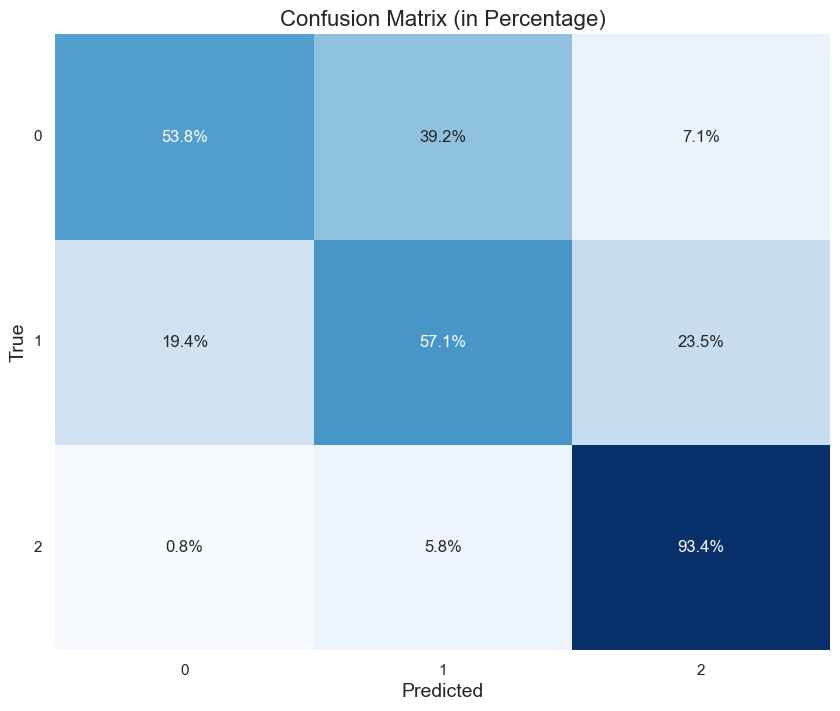

In [1006]:
#Plot confusion matrix
plot_confusion_matrix(yactual, ypred, class_names_2)

In [929]:
tuned_test_table = get_metrics_as_dataframe("tuned_model_on_test_data", tuned_model)
tuned_test_table

,Model,Accuracy,Precision,Recall,F1 Score
0,tuned_model_on_test_data,0.848723,0.860118,0.848723,0.852878


## Summary

In [1008]:
combined_tables = pd.concat([five_class_table, three_class_table, binary_table, tuned_full_table, tuned_test_table ], axis=0)
combined_tables = combined_tables.reset_index(drop=True)
combined_tables

,Model,Accuracy,Precision,Recall,F1 Score
0,BERT base (5 classes),0.566092,0.653298,0.566092,0.592059
1,Three_class_table,0.793413,0.771015,0.793413,0.776169
2,binary classification,0.837224,0.849638,0.837224,0.841782
3,tuned_full_table,0.970203,0.970677,0.970203,0.970357
4,tuned_model_on_test_data,0.848723,0.860118,0.848723,0.852878
